This is not a self-contained notebook. We need to import a bunch of AQC scripts.

In [1]:
import sys
sys.path.append('../../')

In [2]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

from compilers.aqc_demo.cnot_structures import full_conn, spin
from compilers.aqc_demo.parametric_circuit import ParametricCircuit
from compilers.aqc_demo.test_sample_data import ORIGINAL_CIRCUIT, INITIAL_THETAS
from compilers.aqc_demo.aqc_optimizers import FISTAOptimizer, GDOptimizer
from compilers.aqc_demo.aqc import AQC

Here we have a randomly generated unitary matrix `ORIGINAL_CIRCUIT` of size `(8,8)` that represents a circuit. The circuit has 3 qubits.

In [3]:
num_qubits = int(np.log2(ORIGINAL_CIRCUIT.shape[0]))
num_qubits

3

A helper function to plot a CNOT structure we want to target in the approximation.

In [4]:
def cnots_to_qc(num_qubits: int, cnots) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)
    for ii, elements in enumerate(cnots[0]):
        circuit.cx(elements - 1, cnots[1][ii] - 1)

    return circuit

We create a spin CNOT structure assuming we have all qubits connected to each other.
Then we plot it as a circuit.

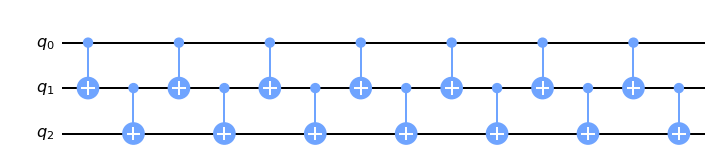

In [5]:
cnots = spin(num_qubits, full_conn(num_qubits))
cnots_qc = cnots_to_qc(num_qubits, cnots)
cnots_qc.draw(output="mpl")

In [6]:
cnots_qc.depth()

14

An instance of `ParametricCircuit` will model a target/approximated circuit. This parametric circuit is built on top of the CNOT structure we created earlier and the number of qubits. In general, it is enough to pass just an instance of CNOT structure since it contains information about qubits. The implementation of `ParametricCicrcuit` to be revised, likely angles should be hidden in `ParametricCircuit`.

We construct an instance of `QuantumCircuit` from a set of randomly chosen angles stored in `INITIAL_THETAS`, the `reverse` parameter tells we want qubit to be ordered in the order supported by Qiskit.

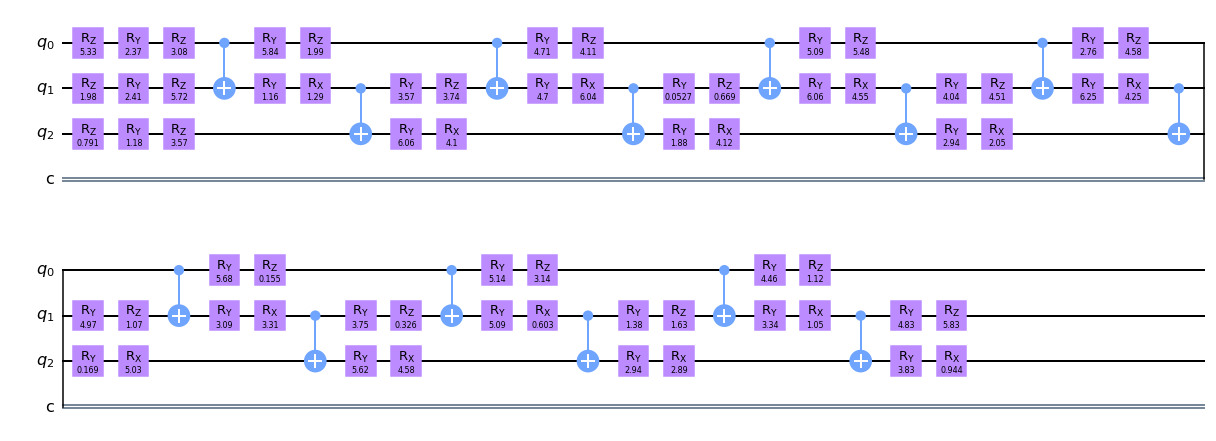

In [7]:
target_circuit = ParametricCircuit(num_qubits, cnots)

initial_thetas_qc = target_circuit.make_circuit(INITIAL_THETAS, reverse=True)
initial_thetas_qc.draw(output="mpl")

In [8]:
initial_thetas_qc.depth()

45

Here we define an error of approximation as a Frobenius norm. We want to minimize the error.

In [9]:
def approximation_error(expected, actual) -> float:
    return .5 * (la.norm(expected - actual, 'fro') ** 2)

Here, we compute a unitary matrix that represents our approximated circuit from a set of initial angles and compare to the original circuit.

In [10]:
target_unitary = target_circuit.compute_unitary(INITIAL_THETAS)
error = approximation_error(ORIGINAL_CIRCUIT, target_unitary)
error

8.269128581814225

We start from FISTA optimizer with some regularization parameters. The output of the optimizer will be used to warm start another optimizer, a pure gradient descent optimizer.
As a result of the call `optimizer.optimize()` we get a new array of angles, that should approximate the circuit better, an array of objective values obtained at each iteration and gradient values (likely we don't need latter two in the final version). The last returned value is `None` in case of FISTA.

In [11]:
optimizer = FISTAOptimizer(method="nesterov", maxiter=5000, eta=0.1, tol=0.01, eps=0.0, reg=0.7, group=True)
thetas, objective, gradient, _ = optimizer.optimize(ORIGINAL_CIRCUIT, INITIAL_THETAS, target_circuit)

Here we construct a circuit from the angles obtained from the optimizer and compute error.

In [12]:
target_unitary = target_circuit.compute_unitary(thetas)
error = approximation_error(ORIGINAL_CIRCUIT, target_unitary)
error

3.5377498694007183

Here we apply some rules to reduce the depth. To be revised.

Then  we create a new circuit based on the compessed CNOT structure and compressed angles.

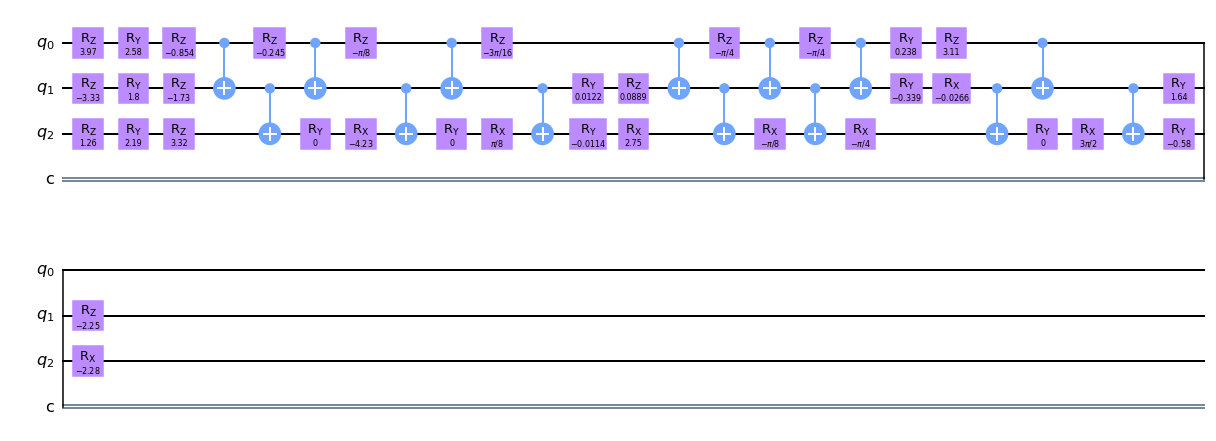

In [13]:
compressed_cnots, compressed_thetas, spar = target_circuit.compress(thetas, synth=False)
compressed_target_circuit = ParametricCircuit(num_qubits, compressed_cnots)
compressed_qc_circuit = compressed_target_circuit.make_circuit(compressed_thetas, reverse=True)
compressed_qc_circuit.draw(output="mpl")

In [14]:
compressed_qc_circuit.depth()

26

On the next step, we create a gradient descent optimizer and optimize the compressed circuit. We pass angles obtained on the first step and the compressed CNOT structure. In general, it is possible to start optimization from a random set of angles.

As an output we get an array of angles, values of the objective function, gradients and the values of angles where the approximation error was minimal.

In [15]:
optimizer = GDOptimizer(method="nesterov", maxiter=5000, eta=0.1, tol=0.01, eps=0.0)
thetas, objective, gradient, thetas_min = optimizer.optimize(ORIGINAL_CIRCUIT, 
                                                             compressed_thetas, 
                                                             compressed_target_circuit)

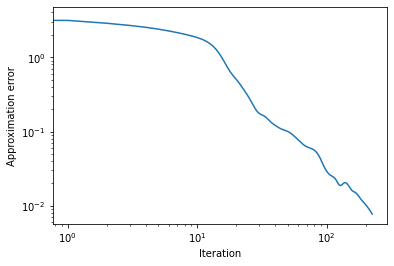

In [16]:
num_iterations = np.shape(objective)[0]
plt.loglog(range(num_iterations), objective)
plt.xlabel('Iteration')
plt.ylabel('Approximation error')
plt.show()

We compute error based on the gradient descent optimization.

In [17]:
target_unitary = compressed_target_circuit.compute_unitary(thetas)
error = approximation_error(ORIGINAL_CIRCUIT, target_unitary)
error

0.007731439188173507

Or instead of all steps above, we can create an instance of `AQC` and compile the original circuit and get the same results.

In [18]:
aqc = AQC(method="nesterov", maxiter=5000, eta=0.1, tol=0.01, eps=0.0, reg=0.7, group=True)
parametric_circuit, thetas = aqc.compile_unitary(ORIGINAL_CIRCUIT, cnots, INITIAL_THETAS)

In [19]:
target_unitary = parametric_circuit.compute_unitary(thetas)
error = approximation_error(ORIGINAL_CIRCUIT, target_unitary)
error

0.007731439188173507

Next step is to create a method `AQC.compile_circuit(qc: QuantumCircuit) -> QuantumCircuit`. In this method we should:
* make use of Qiskit's `tranpile` function to reduce the depth of the circuit
* convert the transpiled circuit to a CNOT like structure by possibly adding additional rotations.
* extract target CNOT structure and initial angles.
* convert the circuit to a unitary.
* compile the circuit to an approximate parametric circuit
* convert the parametric circuit back to a quantum circuit